In [1]:
import pandas as pd

In [37]:
df = pd.read_csv("train_features2.csv")

In [23]:
df.shape

(36765, 28)

In [4]:
df.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness', 'spelling_errors', 'grammar_errors',
       'punctuation_marks', 'text_length', 'sent_count', 'word_count',
       'sybl_count', 'char_count', 'polysyblword_count', 'dalechall_score',
       'flesch_score', 'fleschkincaid_score', 'gunningfog_score', 'smog_score',
       'stop_words', 'lexical_types', 'clauses_prop', 'sub_clauses_prop',
       'verb_phrases_prop', 'noun_phrases_prop', 'chars_per_word',
       'words_per_sentence', 'sybl_per_sentence'],
      dtype='object')

In [5]:
df.dtypes

discourse_id                object
essay_id                    object
discourse_text              object
discourse_type              object
discourse_effectiveness     object
spelling_errors              int64
grammar_errors               int64
punctuation_marks            int64
text_length                  int64
sent_count                 float64
word_count                 float64
sybl_count                 float64
char_count                 float64
polysyblword_count         float64
dalechall_score            float64
flesch_score               float64
fleschkincaid_score        float64
gunningfog_score           float64
smog_score                 float64
stop_words                   int64
lexical_types                int64
clauses_prop               float64
sub_clauses_prop           float64
verb_phrases_prop          float64
noun_phrases_prop          float64
chars_per_word             float64
words_per_sentence         float64
sybl_per_sentence          float64
dtype: object

In [38]:
df2 = df.drop(["discourse_id","essay_id","discourse_type"], axis=1)

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, concatenate, Flatten, Dropout

# Cargar el DataFrame (reemplaza 'nombre_del_archivo.csv' con el nombre de tu archivo)

# Preprocesamiento del texto
max_words = 1000  # Número máximo de palabras a considerar en el vocabulario
maxlen = 100  # Longitud máxima de las secuencias de texto

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df2['discourse_text'])  # Reemplaza 'texto_columna' por el nombre de la columna que contiene texto
sequences = tokenizer.texts_to_sequences(df2['discourse_text'])
X_text = pad_sequences(sequences, maxlen=maxlen)

# Preprocesamiento de las variables numéricas
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df2.drop(columns=['discourse_text', 'discourse_effectiveness']))

# Codificación de la variable categórica 'discourse_efectiveness'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df2['discourse_effectiveness'])
y = to_categorical(y)  # Convertir a representación one-hot

# División de los datos en conjuntos de entrenamiento y prueba
X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# Definición del modelo de red neuronal
text_input = Input(shape=(maxlen,))
embedding = Embedding(input_dim=max_words, output_dim=50, input_length=maxlen)(text_input)
conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
pooling = GlobalMaxPooling1D()(conv1d)
text_output = Dense(64)(pooling)

numeric_input = Input(shape=(X_numeric.shape[1],))
numeric_output = Dense(64)(numeric_input)

combined = concatenate([text_output, numeric_output])

x = Dense(128, activation='relu')(combined)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=[text_input, numeric_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
model.fit([X_text_train, X_numeric_train], y_train, epochs=10, batch_size=128, validation_data=([X_text_test, X_numeric_test], y_test))


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 50)              50000     ['input_6[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 98, 128)              19328     ['embedding_2[0][0]']         
                                                                                                  
 global_max_pooling1d_2 (Gl  (None, 128)                  0         ['conv1d_2[0][0]']            
 obalMaxPooling1D)                                                                          

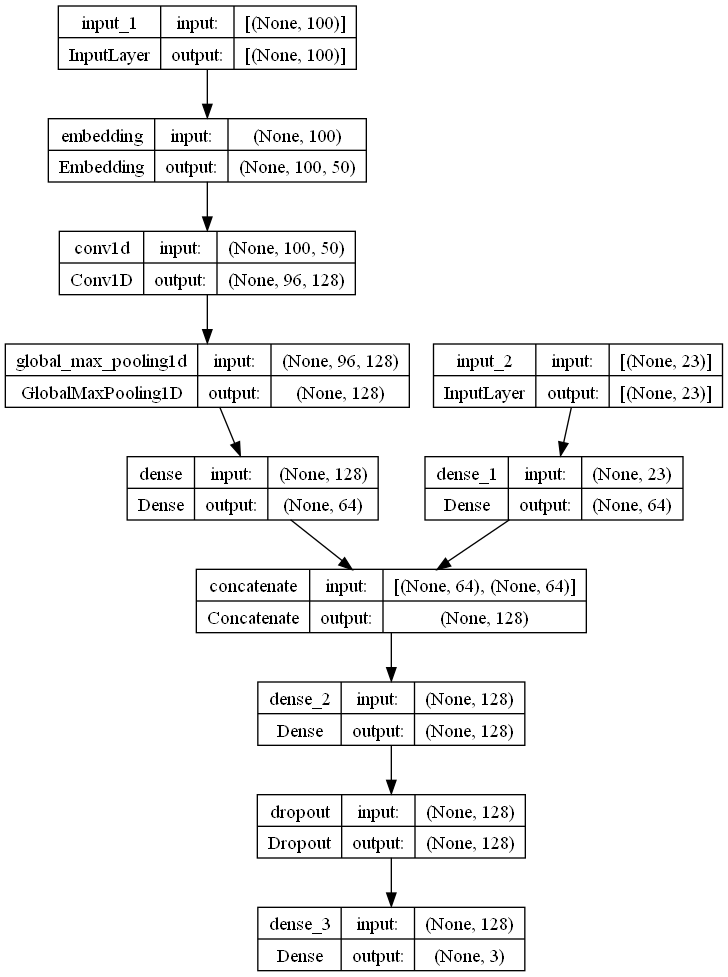

In [16]:
from keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [22]:
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df2.drop(columns=['discourse_text', 'discourse_effectiveness']))

# Codificación de la variable categórica 'discourse_efectiveness'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df2['discourse_effectiveness'])

# División de los datos en conjuntos de entrenamiento y prueba
X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# Definición del modelo de red neuronal solo para variables numéricas
numeric_input = Input(shape=(X_numeric.shape[1],))
x = Dense(128, activation='relu')(numeric_input)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=numeric_input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
model.fit(X_numeric_train, y_train, epochs=10, batch_size=32, validation_data=(X_numeric_test, y_test))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_8 (Dense)             (None, 128)               3072      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 11523 (45.01 KB)
Trainable params: 11523 (45.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
920/920 [===

In [26]:
df3=df2.drop(["discourse_text"], axis=1)

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
X = df3.drop(columns=['discourse_effectiveness'])
y = df3['discourse_effectiveness']

# Codificación de la variable categórica 'discourse_efectiveness'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo XGBoost
model = XGBClassifier(objective='multi:softmax', num_class=3)  # 3 clases en 'discourse_efectiveness'
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred2 = model.predict(X_train)


# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')
print(f"Precision del Modelo en Training: ",accuracy_score(y_train, y_pred2))

Precisión del modelo: 0.6318509451924385
Precision del Modelo en Training:  0.7475860193118455


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Cargar el DataFrame (reemplaza 'nombre_del_archivo.csv' con el nombre de tu archivo)

# Definir la longitud máxima del texto
maxlen = max(df2["text_length"])  # Actualiza con la longitud máxima que desees

# Preprocesamiento del texto
max_words = 1000  # Número máximo de palabras a considerar en el vocabulario

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df2['discourse_text'])  # Reemplaza 'texto_columna' por el nombre de la columna que contiene texto
sequences = tokenizer.texts_to_sequences(df2['discourse_text'])
X_text = pad_sequences(sequences, maxlen=maxlen)

# Codificación de la variable categórica 'discourse_efectiveness'
y = label_encoder.fit_transform(df2['discourse_effectiveness'])
y = to_categorical(y)

# División de los datos en conjuntos de entrenamiento y prueba
X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# Definición del modelo de red neuronal solo para texto
text_input = Input(shape=(maxlen,))
embedding = Embedding(input_dim=max_words, output_dim=50, input_length=maxlen)(text_input)
conv1d = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
pooling = GlobalMaxPooling1D()(conv1d)
hidden = Dense(64, activation='relu')(pooling)
dropout = Dropout(0.1)(hidden)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=text_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
model.fit(X_text_train, y_train, epochs=10, batch_size=32, validation_data=(X_text_test, y_test))



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4131)]            0         
                                                                 
 embedding_7 (Embedding)     (None, 4131, 50)          50000     
                                                                 
 conv1d_7 (Conv1D)           (None, 4127, 128)         32128     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                           

KeyboardInterrupt: 